In [7]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Crear carpeta para resultados
carpeta_salida = "resultados_deriva"
os.makedirs(carpeta_salida, exist_ok=True)

# Parametros de la simulacion
tam_poblacion = 5
num_alelos = 2 * tam_poblacion
num_generaciones = 20
generaciones = list(range(num_generaciones + 1))
num_replicas = 20

def una_simulacion(num_alelos, generaciones):
    """Simula deriva genetica con modelo Wright-Fisher."""
    estado = ['A2'] * num_alelos
    pos_a1 = random.sample(range(num_alelos), 3)
    for i in pos_a1:
        estado[i] = 'A1'

    frec = []
    hetero = []

    p0 = estado.count('A1') / num_alelos
    frec.append(p0)
    hetero.append(2 * p0 * (1 - p0))

    for g in generaciones[1:]:
        nueva = [random.choice(estado) for _ in range(num_alelos)]
        estado = nueva
        p = estado.count('A1') / num_alelos
        frec.append(p)
        hetero.append(2 * p * (1 - p))

    return frec, hetero


# Guardar resultados de replicas
todas_frec = np.zeros((num_replicas, len(generaciones)))
todas_hetero = np.zeros((num_replicas, len(generaciones)))
lista_dfs = []

for r in range(num_replicas):
    frec, hetero = una_simulacion(num_alelos, generaciones)
    todas_frec[r, :] = frec
    todas_hetero[r, :] = hetero

    df = pd.DataFrame({
        "generacion": generaciones,
        "frec_A1": frec,
        "hetero": hetero
    })

    nombre_archivo = os.path.join(carpeta_salida, f"replica_{r+1}.csv")
    df.to_csv(nombre_archivo, index=False)
    lista_dfs.append(df.rename(columns={"frec_A1": f"frec_rep{r+1}", "hetero": f"H_rep{r+1}"}))

# Combinar todo en un solo CSV
df_final = lista_dfs[0].copy()
for df in lista_dfs[1:]:
    df_final = df_final.merge(df, on="generacion")

df_final["frec_media"] = todas_frec.mean(axis=0)
df_final["hetero_media"] = todas_hetero.mean(axis=0)

ruta_combinada = os.path.join(carpeta_salida, "resultados_combinados.csv")
df_final.to_csv(ruta_combinada, index=False)

# === ESTADISTICAS FINALES ===
ultima_frec = todas_frec[:, -1]
ultima_hetero = todas_hetero[:, -1]

fijados = np.sum(ultima_frec == 1) / num_replicas
perdidos = np.sum(ultima_frec == 0) / num_replicas
frec_media_final = np.mean(ultima_frec)
hetero_media_final = np.mean(ultima_hetero)

print("\n=== Estadisticas finales (t = 20) ===")
print(f"Frecuencia media de A1: {frec_media_final:.3f}")
print(f"Heterocigosidad media: {hetero_media_final:.3f}")
print(f"Proporcion de replicas con A1 fijado (p=1): {fijados:.2%}")
print(f"Proporcion de replicas con A1 perdido (p=0): {perdidos:.2%}")





=== Estadisticas finales (t = 20) ===
Frecuencia media de A1: 0.235
Heterocigosidad media: 0.021
Proporcion de replicas con A1 fijado (p=1): 20.00%
Proporcion de replicas con A1 perdido (p=0): 75.00%


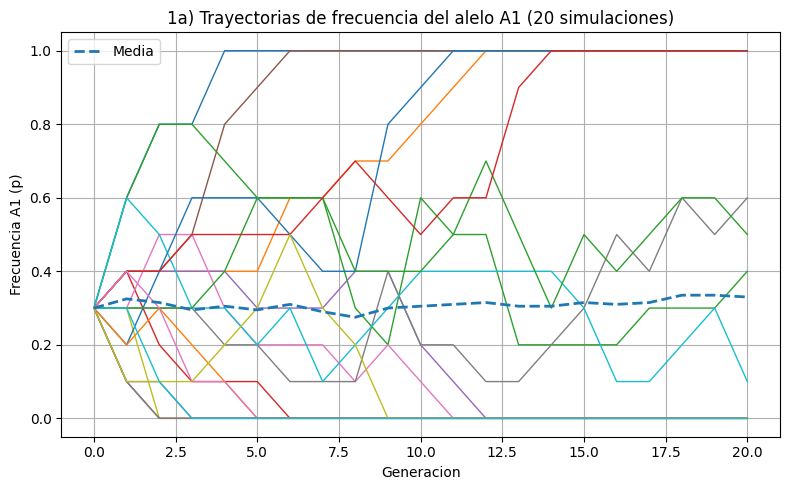

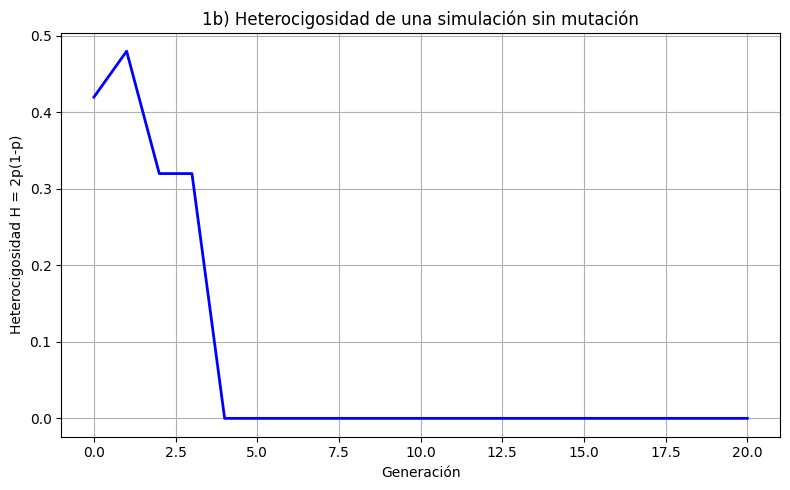

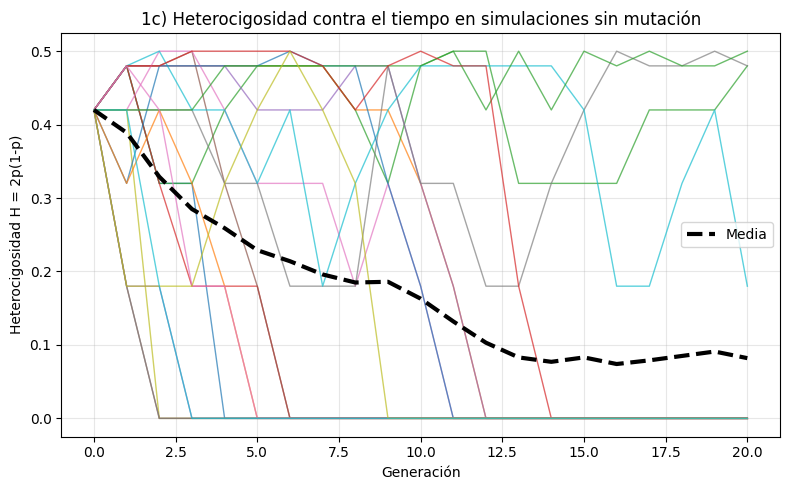

In [6]:
# === GRAFICAS ===

# Gráfica 1a: Frecuencias de A1 de TODAS las simulaciones (20 líneas)
plt.figure(figsize=(8,5))
for r in range(num_replicas):
    plt.plot(generaciones, todas_frec[r, :], linewidth=1)
plt.plot(generaciones, df_final["frec_media"], "--", linewidth=2, label="Media")
plt.xlabel("Generacion")
plt.ylabel("Frecuencia A1 (p)")
plt.title("1a) Trayectorias de frecuencia del alelo A1 (20 simulaciones)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfica 1b: Heterocigosidad de UNA simulación individual
plt.figure(figsize=(8,5))
# Escoge una réplica al azar (por ejemplo la primera)
plt.plot(generaciones, todas_hetero[0, :], 'b-', linewidth=2, label="Réplica 1")
plt.xlabel("Generación")
plt.ylabel("Heterocigosidad H = 2p(1-p)")
plt.title("1b) Heterocigosidad de una simulación sin mutación")
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfica 1c: Heterocigosidad de TODAS las simulaciones
plt.figure(figsize=(8,5))
for r in range(num_replicas):
    plt.plot(generaciones, todas_hetero[r, :], linewidth=1, alpha=0.7)
plt.plot(generaciones, df_final["hetero_media"], "k--", linewidth=3, label="Media")
plt.xlabel("Generación")
plt.ylabel("Heterocigosidad H = 2p(1-p)")
plt.title("1c) Heterocigosidad contra el tiempo en simulaciones sin mutación")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()